In [1]:
#load in packages
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Levenshtein
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size':20})

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Read in all study data from API

In [2]:
import urllib, json
url = "http://www.cbioportal.org/api/studies"
response = urllib.urlopen(url)
all_studies = json.loads(response.read())

In [3]:
studies=[]
study_attributes = []

#takes some time to download data via api
for study in all_studies:
    studyID = study['studyId']
    study_api_url = 'http://cbioportal.org/api/studies/' + studyID + '/clinical-attributes'
    df = pd.read_json(study_api_url)
    
    #make sure the study has data
    if not df.empty:
        studies.append((studyID ,df))
        study_attributes.append((studyID ,df['clinicalAttributeId'].tolist()))

In [4]:
study_names=[]
for study in study_attributes:
    study_names.append(study[0])

In [30]:
#transform data into binary table of studies/attributes
#entries in the table are 1 if a study contains an attribute and 0 otherwise
study_attribute = []
for i in study_attributes:
    for j in i[1]:
        study_attribute.append((i[0],j))

study_attribute_pairs = pd.DataFrame.from_records(study_attribute, columns = ['study','attribute'])

study_data_nolabel = pd.get_dummies(study_attribute_pairs['attribute'])

study_data_combined = pd.concat([study_attribute_pairs['study'], study_data_nolabel], axis=1)
study_data_combined = study_data_combined.groupby('study').sum()


##Choose random study to serve as a "new" study and print the attributes

In [6]:
#split data into test studies
#choose test study
import random
test_study = random.choice(study_names)

#drop study from combined data
study_data_combined.drop(test_study, axis=0, inplace=True)

In [7]:
test_study

u'mbl_icgc'

In [8]:
test_study_api_url = 'http://cbioportal.org/api/studies/' + test_study + '/clinical-attributes'
test_study_data = pd.read_json(test_study_api_url)
test_study_data['clinicalAttributeId']

0                          AGE
1                  CANCER_TYPE
2         CANCER_TYPE_DETAILED
3                 CLIN_M_STAGE
4                       GENDER
5                   GENE_PANEL
6                    HISTOLOGY
7                    OS_MONTHS
8                    OS_STATUS
9                   PFS_MONTHS
10    PRIMARY_SITE_PROGRESSION
11                  RADICALITY
12                    SUBGROUP
Name: clinicalAttributeId, dtype: object

##Find possible matching studies

In [9]:
#calculate the Levenshtein ratio for all pairs
all_col_names = list(study_data_combined)
new_study_attributes = test_study_data['clinicalAttributeId']
#total_attributes = len(all_col_names)
lev_dist = np.zeros([len(all_col_names), len(new_study_attributes)])
for i in range(len(all_col_names)):
    for j in range(len(new_study_attributes)):
        lev_dist[i,j]=Levenshtein.ratio(all_col_names[i].upper(), new_study_attributes[j].upper())

In [11]:
#find pairs of studies which might be a match (via levenshtein test)
#add check to see if attributes are part of the same study
test=pd.DataFrame(data=lev_dist.T,
index=new_study_attributes, 
columns=all_col_names)
df_test = pd.DataFrame(data=list(test[test > 0.85].stack().index))

##Print possible matching attributes along with datatype

In [12]:
from collections import Counter
sample_or_patient = {True:"patient", False:"sample"}

for attribute in new_study_attributes:
    #print attribute in new study along with datatype and patient/sample attribute
    print "new study attribute: " + attribute
    print "datatype: " + test_study_data[test_study_data['clinicalAttributeId']==attribute]['datatype'].values[0]
    print "patient attribute?: " + str(test_study_data[test_study_data['clinicalAttributeId']==attribute]['patientAttribute'].values[0])
    print '---------------------------------------'
    #print similar attributes found in existing studies along with the datatype
    print 'possible matches:'
    
    #print matching attributes 
    for matching_attribute in df_test[df_test[0]==attribute][1].values:
        print matching_attribute
        studies_with_attribute=study_data_combined[study_data_combined[matching_attribute]>0].index    
        attribute_dtypes=[]
        attribute_ps_types=[]
        for study in studies_with_attribute:
            study_index=study_names.index(study)

            attribute_data=studies[study_index][1]
            attribute_dtype=attribute_data[attribute_data['clinicalAttributeId']==matching_attribute]['datatype']
            attribute_dtypes.append(attribute_dtype.get_values()[0])

            attribute_ps_type=attribute_data[attribute_data['clinicalAttributeId']==matching_attribute]['patientAttribute']
            attribute_ps_types.append(sample_or_patient[attribute_ps_type.get_values()[0]])
            
        print Counter(attribute_dtypes)
        print Counter(attribute_ps_types)
    
    print ''
    
    

new study attribute: AGE
datatype: NUMBER
patient attribute?: True
---------------------------------------
possible matches:
AGE
Counter({u'NUMBER': 121})
Counter({'patient': 121})

new study attribute: CANCER_TYPE
datatype: STRING
patient attribute?: False
---------------------------------------
possible matches:
CANCER_TYPE
Counter({u'STRING': 145})
Counter({'sample': 145})

new study attribute: CANCER_TYPE_DETAILED
datatype: STRING
patient attribute?: False
---------------------------------------
possible matches:
CANCER_TYPE_DETAILED
Counter({u'STRING': 146})
Counter({'sample': 146})

new study attribute: CLIN_M_STAGE
datatype: STRING
patient attribute?: True
---------------------------------------
possible matches:
CLIN_M_STAGE
Counter({u'STRING': 13})
Counter({'patient': 13})
CLIN_N_STAGE
Counter({u'STRING': 9})
Counter({'patient': 9})
CLIN_T_STAGE
Counter({u'STRING': 12})
Counter({'patient': 12})

new study attribute: GENDER
datatype: STRING
patient attribute?: True
------------

##Number of attributes in common between two studies

In [13]:
existing_study_names = list(study_data_combined.T)
n_studies = study_data_combined.shape[0]
#n_common_attributes = pd.DataFrame(index=existing_study_names, columns=test_study)
#n_common_attributes = n_common_attributes.fillna(0.0)
#n_attribute_dist = []
#n_common_attributes = np.zeros([n_studies, n_studies])

#iterate over studies and their attributes, should make this cleaner with dataframes eventually
n_common_attributes_all = []
n_common_attributes_normalized = []
for existing_study in list(study_data_combined.T):
    n_common_attributes = 0
    for new_attribute in new_study_attributes:
        for existing_attribute in list(study_data_combined.T[study_data_combined.T[existing_study]>0].index):
            if new_attribute == existing_attribute:
                n_common_attributes += 1
    
    n_common_attributes_all.append(n_common_attributes)
    n_common_attributes_normalized.append(n_common_attributes/min(float(len(new_study_attributes)), list(study_data_combined.T[study_data_combined.T[existing_study]>0].index)))
    #n_common_attributes[i, j] = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
    #n_attributes = sum((study_data_combined.T[existing_study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
    #n_common_attributes.ix[i, study_names[j]] = n_attributes
    #if j>i:
        #n_attribute_dist.append(n_attributes)

##Histogram of attributes in common between new study and studies on cBioPortal

acyc_mskcc_2013
7


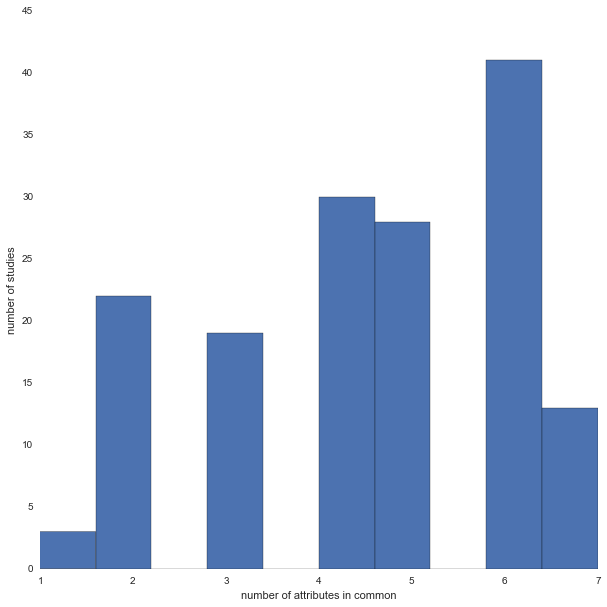

In [22]:
#find study with most attributes in common
plt.hist(n_common_attributes_all)
plt.xlabel("number of attributes in common")
plt.ylabel("number of studies")
print list(study_data_combined.T)[np.argmax(n_common_attributes_all)]
print np.max(n_common_attributes_all)

##Sum attributes in common across other studies

In [31]:
study_names = list(study_data_combined.T)
n_studies = len(study_names)
n_common_attributes = pd.DataFrame(index=study_names, columns=study_names)
n_common_attributes = n_common_attributes.fillna(0.0)
n_attribute_dist = []
#n_common_attributes = np.zeros([n_studies, n_studies])

for i in range(n_studies):
    for j in range(n_studies):
        #n_common_attributes[i, j] = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        n_attributes = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        n_common_attributes.ix[i, study_names[j]] = n_attributes
        if j>i:
            n_attribute_dist.append(n_attributes)

In [32]:
sum_common_attributes = pd.DataFrame(n_common_attributes.sum()).sort(columns=0, ascending=False)

###Histogram of the sum of attributes in common for each study

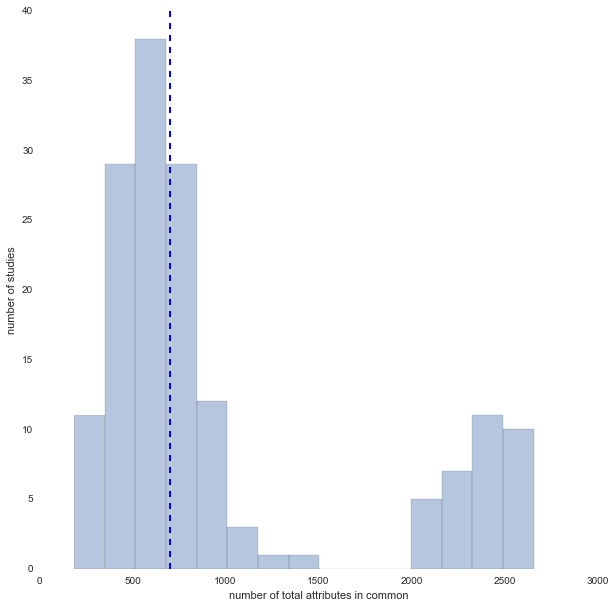

In [33]:
ax=seaborn.distplot(sum_common_attributes, kde=False)
ax.set(ylabel='number of studies', xlabel='number of total attributes in common')
plt.axvline(sum(n_common_attributes_all), color='b', linestyle='dashed', linewidth=2)
plt.show()

##Normalized number of attributes in common between studies

In [18]:
study_names = list(study_data_combined.T)
n_studies = len(study_names)
n_common_attributes = pd.DataFrame(index=study_names, columns=study_names)
n_common_attributes = n_common_attributes.fillna(0.0)
n_attribute_dist = []
#n_common_attributes = np.zeros([n_studies, n_studies])

for i in range(n_studies):
    for j in range(n_studies):
        #n_common_attributes[i, j] = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        n_attributes = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        min_attributes = min([sum(study_data_combined.T[study_names[i]]>0), sum(study_data_combined.T[study_names[j]]>0)])
        n_common_attributes.ix[i, study_names[j]] = n_attributes/float(min_attributes)
        if j>i:
            n_attribute_dist.append(n_attributes)

In [19]:
sum_norm_common_attributes = pd.DataFrame(n_common_attributes.sum()).sort(columns=0, ascending=False)

###Histogram of the sum of normalized attributes in common for each study

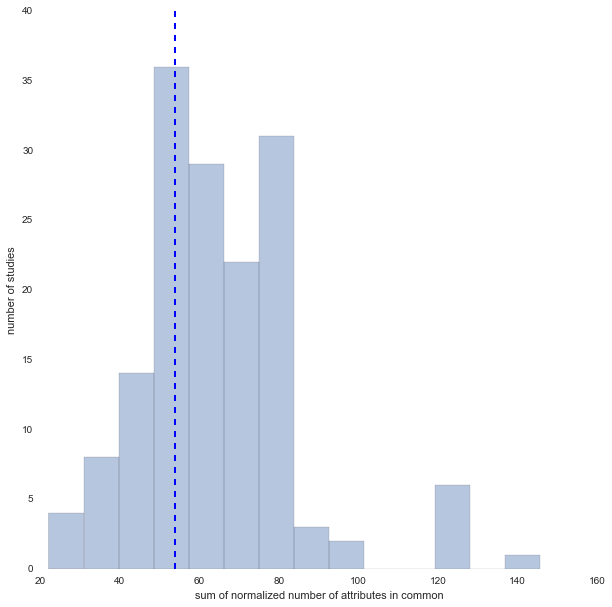

In [34]:
ax=seaborn.distplot(sum_norm_common_attributes, kde=False)
ax.set(ylabel='number of studies', xlabel='sum of normalized number of attributes in common')
plt.axvline(sum(n_common_attributes_normalized), color='b', linestyle='dashed', linewidth=2)
plt.show()